# GMODuck
A genetically modified yellow qantum duck who is competing in QHack 2021 Open Hackathon. This duck is capable of building QML circuits using genetic programming without having any idea why his model works but he assures it's the best.

## Setup

In [1]:
import sys
print (sys.version)

3.8.5 (default, Sep  4 2020, 02:22:02) 
[Clang 10.0.0 ]


In [2]:
%%capture

# Comment this out if you don't want to install pennylane from this notebook
!pip install pennylane

# Comment this out if you don't want to install matplotlib from this notebook
!pip install matplotlib

# Comment this out if you don't want to install sklearn from this notebook
!pip install sklearn

In [3]:
# Imports
import random
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics as metrics

np.random.seed(42)

In [4]:
dev = qml.device('default.qubit', wires=2)

## Data

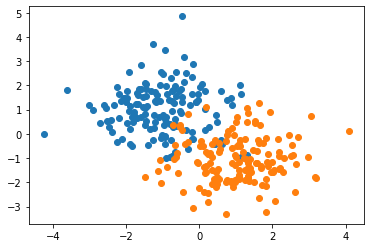

In [5]:
# This Data example is copied from the CERN workshop
n_samples = 300
X0 = np.array([[np.random.normal(loc=-1, scale=1), 
                np.random.normal(loc=1, scale=1)] for i in range(n_samples//2)]) 
X1 = np.array([[np.random.normal(loc=1, scale=1), 
                np.random.normal(loc=-1, scale=1)] for i in range(n_samples//2)]) 
X = np.concatenate([X0, X1], axis=0)
Y = np.concatenate([-np.ones(int(n_samples/2)), np.ones(int(n_samples/2))], axis=0)
data = list(zip(X, Y))

plt.scatter(X0[:,0], X0[:,1])
plt.scatter(X1[:,0], X1[:,1])
plt.show()

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=1)
data_train = list(zip(X_train, y_train))
data_test  = list(zip(X_test, y_test))

In [6]:
# Init conditions
#in_str = None
#in_str_len = None
in_str = '01011011'
in_str_len = len(in_str)
population = 8
generations = 5
threshold = 0.95

## Agents to evolve 

In [7]:
class Agent:
    def __init__(self, length):
        self.string = ''.join(str(random.randint(0,1)) for _ in range(length))
        self.fitness = -1

    def __str__(self):
        return 'String: ' + str(self.string) + ' Fitness: ' + str(self.fitness)

In [8]:
def ga():
    agents = init_agents(population, in_str_len)
    
    for generation in range(generations):
        print("Generation: ", str(generation))
        
        agents = fitness(agents)
        agents = selection(agents)
        agents = crossover(agents)
        agents = mutation(agents)
        
        if any(agent.fitness >= threshold for agent in agents):
            print("Thereshold has been met! Winning genome: ", agent.string)

In [9]:
def init_agents(population, length):
    return [Agent(length) for _ in range(population)]

## Fitness and definition of Quantum Model

In [10]:
def fitness(agents):
    for agent in agents:
        global genome
        genome = agent.string
        
        # Build a quantum model
        @qml.qnode(dev)
        def quantum_model(x,w):
            # Encoding
            encode_gene = genome[:2]
            if encode_gene == "00" or "11":
                qml.templates.AngleEmbedding(x, wires=[0, 1])
            elif encode_gene == "01":
                qml.templates.AmplitudeEmbedding(x, wires=[0, 1],pad=1,normalize=True)
            elif encode_gene == "10":
                qml.templates.IQPEmbedding(x, wires=[0, 1])

            RZ_gene = genome[2:4]
            if RZ_gene == "01":
                qml.RZ(0.1,wires=0)
            elif RZ_gene == "10":
                qml.RZ(0.1,wires=1)
            elif RZ_gene == "11":
                qml.RZ(0.1,wires=0)
                qml.RZ(0.1,wires=1)

            Entanglement_gene = genome[4:5]
            if Entanglement_gene == "1" or "0": #Forcing entanglement
                qml.templates.BasicEntanglerLayers(w, wires=[0, 1])

            T_gene = genome[5:7]
            if T_gene == "01":
                qml.T(wires=0)
            elif T_gene == "10":
                qml.T(wires=1)
            elif T_gene == "11":
                qml.T(wires=0)
                qml.T(wires=1)

            CNOT_gene = genome[7:8]
            if Entanglement_gene == "1":
                qml.CNOT(wires=[0,1])

            return qml.expval(qml.PauliZ(wires=0))
      
        # Cost function
        def loss(a, b):
            return (a - b)**2

        def average_loss(w, data):
            c = 0
            for x, y in data:
                prediction = quantum_model(x, w)
                c += loss(prediction, y)
            return c/len(data)

        # Gradient
        gradient_fn = qml.grad(average_loss, argnum=0)

        # Trainning
        w_init = np.array([[1.1, -2], [2, -1], [-2, 1]])

        w = np.array(w_init)

        history = []

        for i in range(20):
            w_new = w - 0.3*gradient_fn(w, data_train)
            avg_loss = average_loss(w_new, data_train)
            history.append(w_new)
            w = w_new

        def pred(w,X):
            y_pred = []
            for x in X:
                prediction = quantum_model(x, w)
                y_pred.append(prediction)
            return y_pred

        y_pred_train = pred(w,X_train)
        y_pred_test  = pred(w,X_test)
        fpr_train, tpr_train, thresholds_train = metrics.roc_curve(y_train, y_pred_train)
        fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_test)

        roc_auc_train = metrics.auc(fpr_train,tpr_train)
        roc_auc = metrics.auc(fpr,tpr)
        
        agent.fitness = roc_auc
    return agents

## Selection

In [11]:
def selection(agents):
    agents = sorted(agents, key=lambda agent: agent.fitness, reverse=True)
    print('\n '.join(map(str, agents)))

    # Natural selection
    kill_param = 0.2 # take the top 20% of the individuals
    agents = agents[:int(kill_param * len(agents))]
    return agents

## Cross over

In [12]:
def crossover(agents):
    offspring = []

    for _ in range( int((population - len(agents))/2)):
        # TODO: don't breed parents that are the same
        parent1 = random.choice(agents)
        parent2 = random.choice(agents)

        child1 = Agent(in_str_len)
        child2 = Agent(in_str_len)
        split = random.randint(0,in_str_len)
        child1.string = parent1.string[0:split] + parent2.string[split:in_str_len]
        child2.string = parent2.string[0:split] + parent1.string[split:in_str_len]

        offspring.append(child1)
        offspring.append(child2)

    agents.extend(offspring)
    return agents

## Mutation

In [13]:
def mutation(agents):
    chance_of_mutation = 0.20
    for agent in agents:
        for idx, param in enumerate(agent.string):
            if random.uniform(0.0,1.0) <= chance_of_mutation:
                agent.string = agent.string[0:idx] + str(random.randint(0,1)) + agent.string[idx+1:in_str_len]
    return agents

## Run the genetic algorithm 

In [14]:
ga()

Generation:  0
String: 10000111 Fitness: 0.9119247897080653
 String: 10011111 Fitness: 0.9119247897080653
 String: 01101010 Fitness: 0.9074715487382484
 String: 00110010 Fitness: 0.9074715487382484
 String: 11111011 Fitness: 0.9074715487382484
 String: 00110010 Fitness: 0.9074715487382484
 String: 10110100 Fitness: 0.9074715487382484
 String: 10111000 Fitness: 0.9074715487382484
Generation:  1
String: 00000111 Fitness: 0.9119247897080653
 String: 00000111 Fitness: 0.9119247897080653
 String: 10000101 Fitness: 0.9119247897080653
 String: 10000111 Fitness: 0.9119247897080653
 String: 10000111 Fitness: 0.9119247897080653
 String: 10000001 Fitness: 0.9119247897080653
 String: 10000110 Fitness: 0.9119247897080653
Generation:  2
String: 00000001 Fitness: 0.9119247897080653
 String: 00000011 Fitness: 0.9119247897080653
 String: 10000111 Fitness: 0.9119247897080653
 String: 00000111 Fitness: 0.9119247897080653
 String: 00000101 Fitness: 0.9119247897080653
 String: 00001111 Fitness: 0.911924789

In [15]:
print("\U0001F986 Qhack Qhack") 

🦆 Qhack Qhack
